# Q9.2
#### (6.75 hours)

Solving Eq. (9.5) for $\dot y$,

\begin{align}
C_\textrm{J} &= n^2\left(x^2 + y^2 \right) + 2\left(\frac{\mu_1}{r_1} + \frac{\mu_2}{r_2} \right) - \dot x^2 - \dot y^2 \\
\dot y &= \left[ n^2\left(x^2 + y^2 \right) + 2\left(\frac{\mu_1}{r_1} + \frac{\mu_2}{r_2} \right) - \dot x^2 - C_\textrm{J} \right]^{1/2}
\tag{A}
\end{align}

In [1]:
def getvy(x, Cj, y=0, vx=0, n=1., m1=1., m2=(1/999), ):
    ''' Determins vy by evaluating Eq. (A) '''
    mu1 = m1/(m1 + m2)
    mu2 = m2/(m1 + m2)
    r1 = ((x + mu2)**2 + y**2)**(1/2)
    r2 = ((x - mu1)**2 + y**2)**(1/2)
    return (n**2*(x**2 + y**2) + 2*(mu1/r1 + mu2/r2) - vx**2 - Cj)**(1/2)

In [2]:
import matplotlib.pyplot as plt

def pplot(xvxs, subtitle, xlim, ylim):
    plt.figure(figsize=[11, 6])
    title = 'Poincaré Map (' + subtitle + ')'
    plt.title(title, fontsize='xx-large')
    plt.xlabel('$x$', fontsize='large')
    plt.ylabel('$\dot x$', fontsize='large')
    plt.scatter(xvxs[:,0], xvxs[:,1], s=.1)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.show()

In [3]:
import rebound
import numpy as np

def pmap(xlim, ylim, Cj=3.03, x0lo=.2, x0hi=.8, integrator='WHFast', pts=500):
    Nout = pts
    x0s = np.arange(x0lo,x0hi,.01)    # range of init. x values
    xvxs = np.zeros((x0s.size*Nout,2)) # for Poincare surface of section
    vy0s = np.zeros(x0s.size)

    for i,x0 in enumerate(x0s):
        vy0s[i] = getvy(x0, Cj)            # determine init. prograde vys

    for i,x0 in enumerate(x0s):        # integrate each init. trajectory
        sim = rebound.Simulation()
        sim.integrator = integrator
        sim.dt = .1
        sim.add(m=1.)
        sim.add(m=1/999, a=1.)         # μ₂ = 10⁻³
        sim.add(x=x0, vy=vy0s[i])
        ps = sim.particles
        exit = False

        for j in range(Nout):          # record up to Nout pairs of x, vx
            if exit:
#                 print('EXIT: x₀ =',x0,', j =',j)
                break
            xvxs[i*Nout+j,0], xvxs[i*Nout+j,1] = ps[2].x, ps[2].vx
            for k in range(10):        # advance out of recording range (y ~ 0)
                sim.move_to_com()
                sim.step()
            while ps[2].y > .1 or ps[2].y < -.1 or ps[2].vy < 0:
                r = (ps[2].x**2 + ps[2].y**2)**(1/2) # radial dist. of particle
                if ps[2].a < .07 or r > 3.: 
                    exit = True        # exit conditions met
                    break
                sim.move_to_com()
                sim.step()             # until y ~ 0 w/ vy > 0 again
    
    pplot(xvxs, integrator, xlim, ylim)

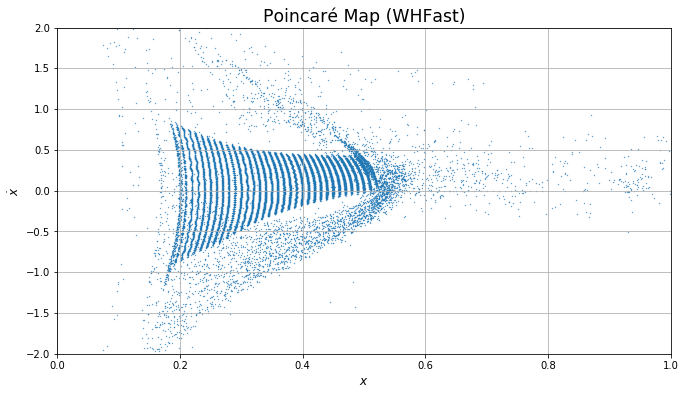

CPU times: user 3.54 s, sys: 14.5 ms, total: 3.55 s
Wall time: 3.55 s


In [4]:
%%time
pmap([0, 1], [-2, 2])

This plot looks starkly different from the [authors' answer (p. 6)](http://ssdbook.maths.qmul.ac.uk/answers.pdf) in the following respects:
- Lack of resonant "islands", crescent or otherwise
- Presence of saturated bands between $0.2 < x < 0.5$, corresponding to results from $0.2 < x_0 < 0.5$

As I was unable to determine what integration scheme the authors used, below I attempt the same procedure using the second-order "Leap Frog" integrator (symplectic).

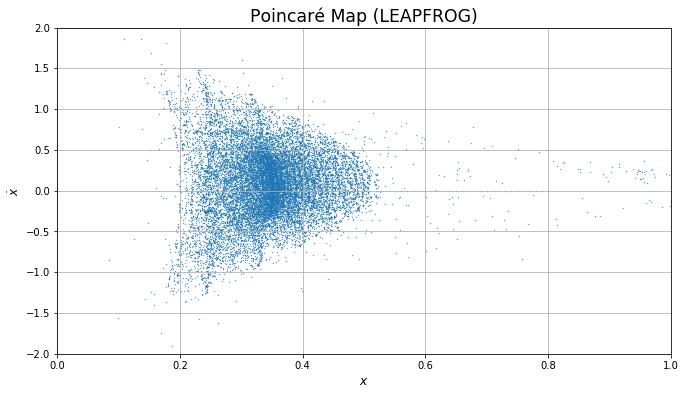

CPU times: user 2.75 s, sys: 0 ns, total: 2.75 s
Wall time: 2.75 s


In [5]:
%%time
pmap([0, 1], [-2, 2], integrator='LEAPFROG')

Although the presence of saturated bands have been removed, the plot still lacks any resonant islands, and the left-hand side still appears concave, while that from the authors is more convex.

# §§9.3.2, 9.3.3 Tests

From the beginning of $\S9.3.2$ on p. 415, 

> "Consider the trajectory of a test particle with starting values $x_0 = 0.55, y_0 = 0$, and $\dot x_0 = 0$, with $\dot y > 0$ determined from the solution of Eq. (9.5) with $C_\textrm{J} = 3.07$... This gives $a_0 = 0.6944$ and $e_0 = 0.2065$ for the initial values."

However, I must first note that I am currently unable to reproduce those initial orbital elements from the given starting Cartesian values (shown below).

In [6]:
x0 = .55

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1/999, a=1.) # μ₂ = 10⁻³
sim.add(x=x0, vy=getvy(x0, Cj=3.07))
ps = sim.particles
print('𝑎₀ = {:.4f}, 𝑒₀ = {:.4f}'.format(ps[2].a, ps[2].e))

𝑎₀ = 0.3594, 𝑒₀ = 0.5277


Without further investigation, it remains unclear whether this discrepancy is a result of: issues with my `getvy()` function; or differences in how REBOUND is computing the orbital elements given this initial state (cf. "We can convert these values to their equivalent... $a$ and... $e$ using the formulae given in Chapter 2", p. 415). However, these discrepancies could be a fundamental source of all qualitative differences between these plots and the authors', as they may impede my test particles from approaching any resonant modes.

Nonetheless, below are unsuccessful attempts to recreate Figs. 9.5 and 9.7.

## Fig. 9.5 Attempt

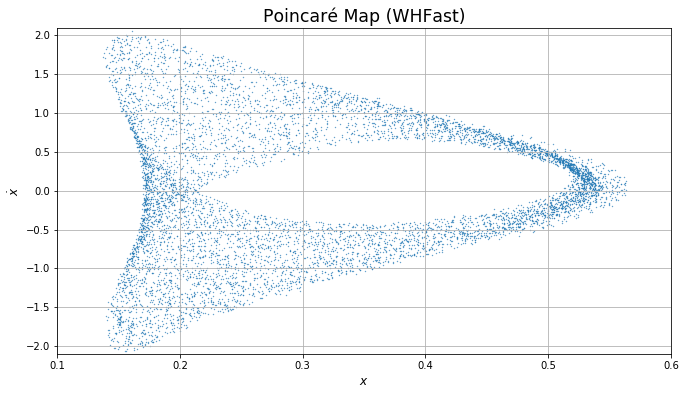

CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.54 s


In [7]:
%%time
pmap([.1, .6], [-2.1, 2.1], x0lo=.55, x0hi=.551, Cj=3.07, pts=int(8e3))

## Fig. 9.7 Attempt

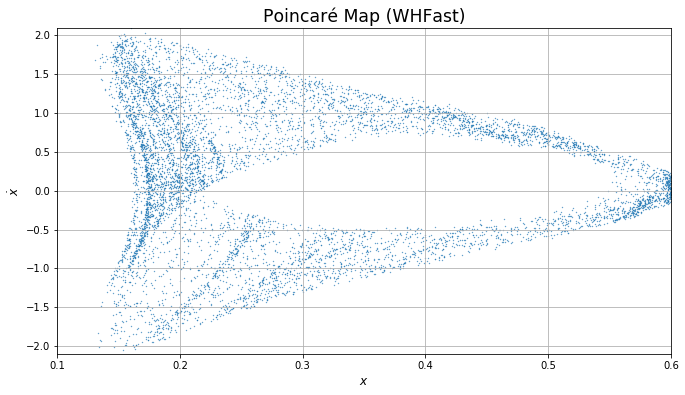

CPU times: user 1.71 s, sys: 9.81 ms, total: 1.72 s
Wall time: 1.72 s


In [8]:
%%time
pmap([.1, .6], [-2.1, 2.1], x0lo=.56, x0hi=.561, Cj=3.07, pts=int(8e3))

**NOTE:** Although the shape is *somewhat* similar to Fig. 9.7, both plots lack the presence of any "resonant" islands.

# §9.4 Tests

I unsuccessfully attempt below to reproduce Figs. 9.16 and 9.17.

## Fig. 9.16 Attempt

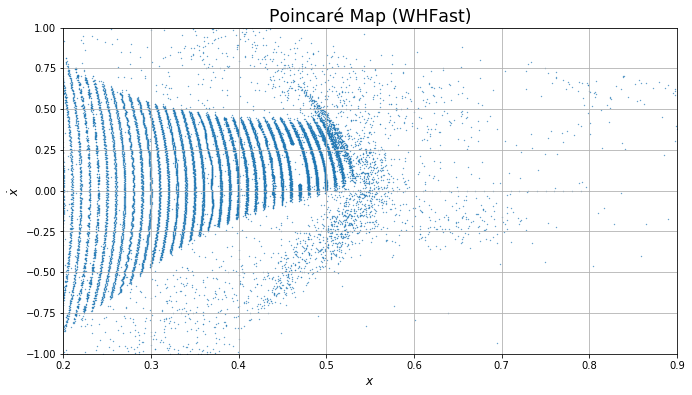

CPU times: user 2.82 s, sys: 9.45 ms, total: 2.83 s
Wall time: 2.83 s


In [9]:
%%time
pmap([.2, .9], [-1, 1], Cj=3.07)

## Fig. 9.17 Attempt

/home/stanley/miniconda3/envs/rebx-3.1.0/lib/python3.8/site-packages/rebound/simulation.py:675: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


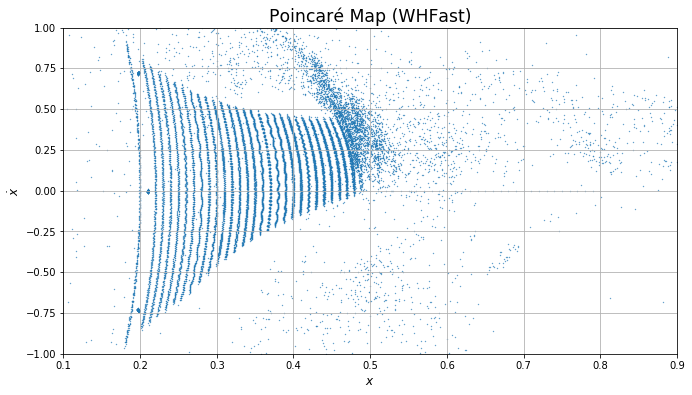

CPU times: user 2.78 s, sys: 19.5 ms, total: 2.8 s
Wall time: 2.79 s


In [10]:
%%time
pmap([.1, .9], [-1, 1], Cj=3.13)

Note what might appear to be the presence of resonant "islands" along $x = 0.2$.

The following attempt with $C_\textrm{J} = 3.01$ also appears to produce what could be resonant islands along $x = 0.275$.

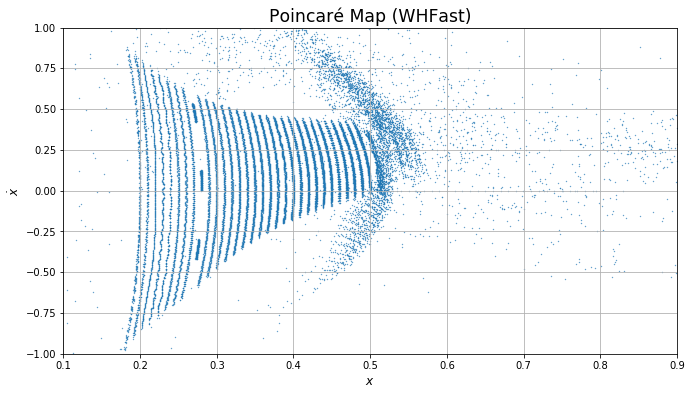

CPU times: user 3.4 s, sys: 0 ns, total: 3.4 s
Wall time: 3.39 s


In [11]:
%%time
pmap([.1, .9], [-1, 1], Cj=3.01)